In [16]:
import astropy.units as u
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np
from astropy.constants import G
from galpy.potential import TwoPowerSphericalPotential, plotPotentials, evaluateDensities
from galpy.util import conversion

In [2]:
data = h5py.File("cutout_598597.hdf5", 'r')

In [3]:
data['PartType1']['SubfindDensity'][:10]
h = data['Header'].attrs['HubbleParam']
m = data['Header'].attrs['MassTable'][1]  / h * u.solMass * 10**10
a = data['Header'].attrs['Time']
l = data['Header'].attrs['BoxSize']


print(h)
print(m)
print(a)
print(l)

0.6774
538464.1418081385 solMass
0.9999999999999998
35000.0


In [4]:
coords = data['PartType1']['Coordinates'][:] / h


In [5]:
def pot_x(x, coord): 
    x_n = np.array([x])
    x_i = np.repeat(x_n, len(coord), axis=0)
    return np.sum((- G*m /np.sqrt(np.sum((x_i - coord)**2, axis=1)) / u.kpc).to(u.m**2 / u.s**2))

In [6]:
l = data['Header'].attrs['BoxSize'] / h

com_coord = np.sum(coords,axis=0) / len(coords)
coords_centred = coords - com_coord
com_dist = np.sqrt(np.sum(coords_centred**2, axis=1))

r_min = np.min(com_dist)
r_max = np.max(com_dist)

x_ = np.linspace(0, l, 10)
y_ = np.linspace(0, l, 10)
z_ = np.linspace(0, l, 10)
potential_points = []
rs = []

for x in x_:
    for y in y_:
        for z in z_:
            potential_points.append(pot_x(np.array([x, y, z]), coords) * u.s**2 / u.m**2 / 1000)
            
            rs.append(np.sqrt((x - com_coord[0])**2 + (y - com_coord[1])**2 + (z - com_coord[2])**2))

In [7]:
axes_size = np.max(coords_centred, axis=0) - np.min(coords_centred, axis=0)
triax_par = (axes_size[1]**2 - axes_size[2]**2) / (axes_size[1]**2 - axes_size[0]**2)
print(triax_par)
print(axes_size[0]/ axes_size[1])

0.8127406609233666
0.6536388833936412


In [8]:
# Define grid
x_ = np.linspace(-2*r_max, 2*r_max, 50)
y_ = np.linspace(-2*r_max, 2*r_max, 50)
z_mid = com_coord[2]  # choose midplane

# Create empty array for potentials
potential_xy = np.zeros((len(y_), len(x_)))

# Compute potential on xy-plane at z=z_mid
for i, x in enumerate(x_):
    for j, y in enumerate(y_):
        r = np.array([x, y, z_mid])
        potential_xy[j, i] = pot_x(r, coords_centred) * u.s**2 / u.m**2  # assume returns scalar potential

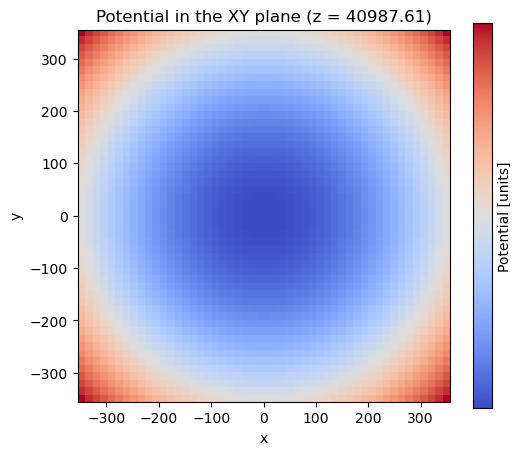

In [9]:
# Plot colormap
plt.figure(figsize=(6,5))
plt.imshow(potential_xy, origin='lower', extent=[-2*r_max, 2*r_max, -2*r_max, 2*r_max], cmap='coolwarm', norm=SymLogNorm(linthresh=1e-2, linscale=0.5, vmin=np.min(potential_xy), vmax=np.max(potential_xy)))
plt.colorbar(label='Potential [units]')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential in the XY plane (z = {:.2f})'.format(z_mid))


plt.show()


In [10]:
print(com_coord)
print(l)

[33208.71250424 10905.23563188 40987.61091333]
51668.142899320934


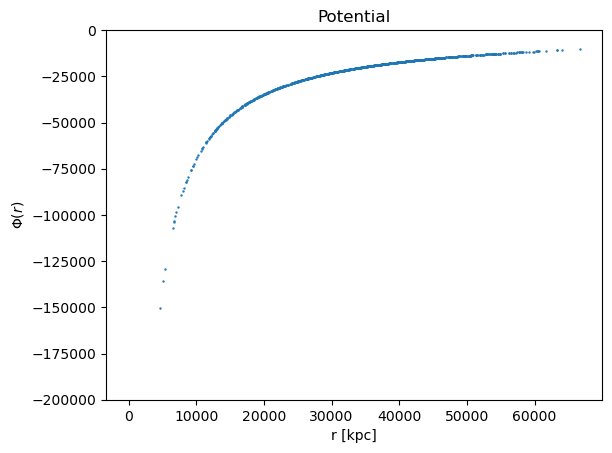

In [25]:

a_kpc = 61.59979773
ampl_solm = 1.408539e+11   
agalpy = a_kpc / 8.0
ampl_galpy = ampl_solm * conversion.mass_in_msol(8.0, 220.0)  # convert to galpy units

Phi = TwoPowerSphericalPotential(amp=ampl_galpy, a=agalpy, alpha=2.137631284420001, beta=15.157640182989251)
r = np.linspace(1, 60000, 1000)
phi_vals = [Phi(r_i / 8.0, 0)for r_i in r]
fig, ax = plt.subplots()
ax.plot(r/ u.kpc, phi_vals)
plt.xlabel("r [kpc]")
plt.ylabel(r"$\Phi(r)$")
plt.title("Potential")
ax.set_ylim(-2*10**5, 0)

ax.scatter(rs, potential_points, s = 0.5)
plt.show()

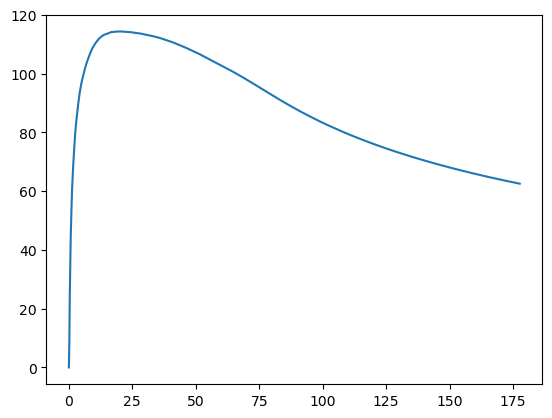

In [96]:
R = np.linspace(0.0000001, r_max, 1000)
v_s = np.zeros(len(rs))
i = 0
for r in R:
    masses = (com_dist < r).sum()
    v_s[i] = (np.sqrt(G * m * masses /(r * u.kpc)).to(u.km/u.s))*u.s /u.km
    i += 1

v_max = np.max(v_s)
fig, ax = plt.subplots()
ax.plot(R, v_s)
plt.show()

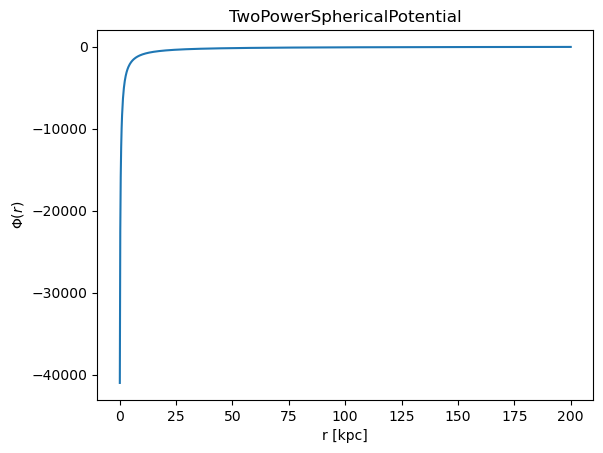

In [101]:

r = np.linspace(0.1, 200, 1000)
phi_vals = [Phi(r_i, 0)*u.s**2/u.km**2 for r_i in r]

fig,ax = plt.subplots()
ax.plot(r, phi_vals)
plt.xlabel("r [kpc]")
plt.ylabel(r"$\Phi(r)$")
plt.title("TwoPowerSphericalPotential")
plt.show()

In [17]:
dens = evaluateDensities(Phi, r/8, 0, phi=None, t=0.0, forcepoisson=False)

In [19]:
def doublepowerlaw(r_kpc, ampl_solm, a_kpc, alpha, beta):
    constant = ampl_solm/(4*np.pi*(a_kpc**3))
    density = constant/(((r_kpc/a_kpc)**alpha)*(1.0+(r_kpc/a_kpc)**(beta-alpha)))
    return density

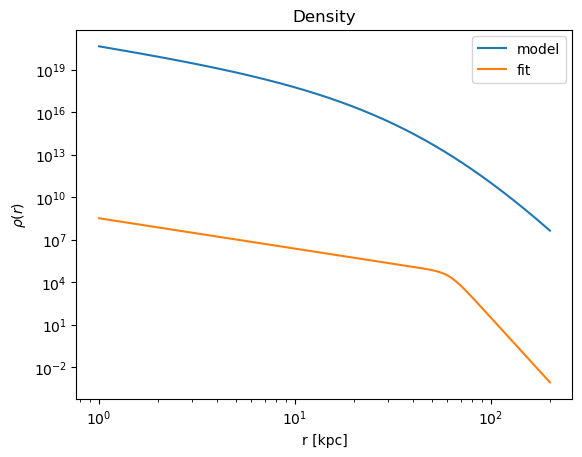

In [24]:
r = np.linspace(1, 200, 1000)
dens_vals = [doublepowerlaw(r_i, 1.408539e+11, 61.59979773,2.137631284420001, 15.157640182989251) for r_i in r]
dens = evaluateDensities(Phi, r/8, 0, phi=None, t=0.0, forcepoisson=False)
fig,ax = plt.subplots()
ax.plot(r/ u.kpc, dens, label='model')
ax.plot(r/ u.kpc, dens_vals, label='fit')
plt.xlabel("r [kpc]")
plt.ylabel(r"$\rho(r)$")
plt.title("Density")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend()
plt.show()

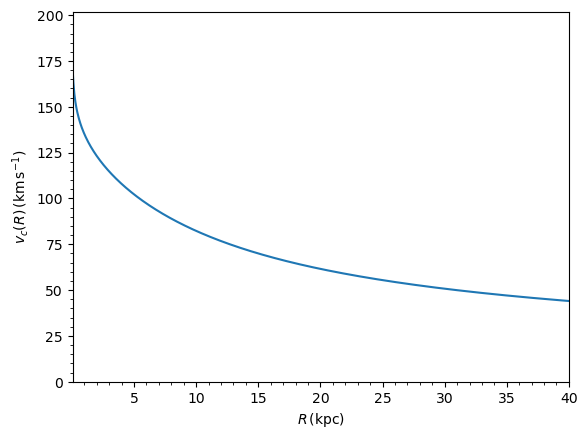

In [104]:
plotRotcurve(Phi)